In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import mglearn

np.random.seed(5)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Read the CSV files into DataFrames
user_activity_1 = pd.read_csv("activity_data_from_2024_01_15_to_2024_02_15.csv")
user_activity_2 = pd.read_csv("activity_data_from_2024_02_16 to 2024_03_10.csv")
user_activity_3 = pd.read_csv("activity_data_from_2024_03_11 to 2024_03_15.csv")

user_activity = pd.concat([user_activity_1, user_activity_2, user_activity_3], ignore_index=True)
del user_activity_1, user_activity_2

In [2]:
print("user_activity dataframe\n")
user_activity


user_activity dataframe



,event_date,event_name,event_params,user_pseudo_id,geo
0,20240115,first_visit,"{\n ""event_params"": [{\n ""key"": ""campaign""...",1.288755e+09,"{\n ""geo"": {\n ""city"": """",\n ""country"":..."
1,20240115,session_start,"{\n ""event_params"": [{\n ""key"": ""source"",\...",1.288755e+09,"{\n ""geo"": {\n ""city"": """",\n ""country"":..."
2,20240115,page_view,"{\n ""event_params"": [{\n ""key"": ""ga_sessio...",1.288755e+09,"{\n ""geo"": {\n ""city"": """",\n ""country"":..."
3,20240115,user_engagement,"{\n ""event_params"": [{\n ""key"": ""campaign""...",1.288755e+09,"{\n ""geo"": {\n ""city"": """",\n ""country"":..."
4,20240115,first_visit,"{\n ""event_params"": [{\n ""key"": ""page_loca...",6.273475e+08,"{\n ""geo"": {\n ""city"": ""Guatemala City"",\n..."
...,...,...,...,...,...
8738,20240315,page_view,"{\n ""event_params"": [{\n ""key"": ""ga_sessio...",4.237026e+08,"{\n ""geo"": {\n ""city"": ""Guatemala City"",\n..."
8739,20240315,scroll,"{\n ""event_params"": [{\n ""key"": ""page_titl...",4.237026e+08,"{\n ""geo"": {\n ""city"": ""Guatemala City"",\n..."
8740,20240315,user_engagement,"{\n ""event_params"": [{\n ""key"": ""page_loca...",4.237026e+08,"{\n ""geo"": {\n ""city"": ""Guatemala City"",\n..."
8741,20240315,page_view,"{\n ""event_params"": [{\n ""key"": ""engagemen...",4.237026e+08,"{\n ""geo"": {\n ""city"": ""Guatemala City"",\n..."


In [3]:
unique_user_id = user_activity["user_pseudo_id"].unique()

user_data = pd.DataFrame(columns = ["User ID"])
user_data["User ID"] = unique_user_id

print("user_data")
user_data

user_data


,User ID
0,1.288755e+09
1,6.273475e+08
2,1.217849e+09
3,3.755862e+07
4,1.028640e+09
...,...
799,1.286691e+09
800,1.492776e+09
801,5.526288e+07
802,6.160002e+08


In [4]:
user_data[["Geographical info", "Engagement page location","Activity"]] = None

print('user_data dataframe\n')
user_data

user_data dataframe



,User ID,Geographical info,Engagement page location,Activity
0,1.288755e+09,None,None,None
1,6.273475e+08,None,None,None
2,1.217849e+09,None,None,None
3,3.755862e+07,None,None,None
4,1.028640e+09,None,None,None
...,...,...,...,...
799,1.286691e+09,None,None,None
800,1.492776e+09,None,None,None
801,5.526288e+07,None,None,None
802,6.160002e+08,None,None,None


In [5]:
page_title_list = []

for _, row in user_activity.iterrows():
    event_params = json.loads(row["event_params"])
    event_name = row["event_name"]
    user_pseudo_id = row["user_pseudo_id"]
    selected_row = user_data.loc[user_data["User ID"] == user_pseudo_id]
    selected_index = selected_row.index[0]
    geo_info = json.loads(row["geo"])
    
    if user_data.at[selected_index, 'Geographical info'] is None:
        user_data.at[selected_index, 'Geographical info'] = geo_info["geo"]["country"]
    
    if  user_data.at[selected_index, 'Activity'] is None: 
        user_data.at[selected_index, 'Activity'] = [event_name]
        
    else:
        user_data.at[selected_index, 'Activity'].append(event_name)
    
    page_title = next((item["value"]["string_value"] for item in event_params.get("event_params", []) if item["key"] == "page_title"), 0)
    engagement_time_msec = next((item["value"]["int_value"] for item in event_params.get("event_params", []) if item["key"] == "engagement_time_msec"), 0)
    page_location = next((item["value"]["string_value"] for item in event_params.get("event_params", []) if item["key"] == "page_location"), 0)

    if engagement_time_msec != 0:
        engagement_time_msec = int(engagement_time_msec)
        selected_page_title_engagement_time_sec = " ".join(["Engagement time msec on", page_title])
        
        if page_title in page_title_list:
            user_data.at[selected_index, selected_page_title_engagement_time_sec] += engagement_time_msec
        else:
            page_title_list.append(page_title)
            new_column_name = ["Engagement time msec on", page_title]
            user_data[" ".join(new_column_name)] = 0
            user_data.at[selected_index, selected_page_title_engagement_time_sec] += engagement_time_msec
            
        if user_data.at[selected_index, 'Engagement page location'] is None:
            user_data.at[selected_index, 'Engagement page location'] = [page_location]
        else:
            user_data.at[selected_index, 'Engagement page location'].append(page_location)
    
    if "first_visit" not in user_data.at[selected_index, 'Activity']:
        user_data.at[selected_index, "Return user"] = "1"
        user_data.at[selected_index, "Event count"] = len(user_data.at[selected_index, "Activity"]) - 1
    else:
        user_data.at[selected_index, "Return user"] = "0"
        user_data.at[selected_index, "Event count"] = len(user_data.at[selected_index, "Activity"])
    
engegement_column = [column for column in user_data.columns if column.startswith('Engagement time msec on')]
user_data.insert(5, "User engagement", user_data[engegement_column].sum(axis = 1))

user_data["Event count"] = user_data["Event count"].astype(int)
user_data["Return user"] = user_data["Return user"].astype(int)

# Export the DataFrame to Excel
user_data.to_excel('user_data.xlsx', index=False)

print('user_data dataframe\n')
user_data

user_data dataframe



,User ID,Geographical info,Engagement page location,Activity,Return user,User engagement,Event count,Engagement time msec on Construcción con Bambú,Engagement time msec on Proyecto de Industrialización del Bambú en Guatemala,Engagement time msec on Construcción,Engagement time msec on Moda,Engagement time msec on Plan de bambú,Engagement time msec on Introducción al plan de bambú,Engagement time msec on Historia del proyecto del Bambú,Engagement time msec on Casa modelo y rancho de reunión hechos de Bambú,Engagement time msec on Comida,Engagement time msec on Capacitación-Proyecto de Industrialización del Bambú en Guatemala,Engagement time msec on Bambú en la Moda,Engagement time msec on Educación,Engagement time msec on Invernadero construido a base de bambú industrializado,Engagement time msec on Transporte,Engagement time msec on Entretenimiento,Engagement time msec on Productos de Bambú,Engagement time msec on Descargas,Engagement time msec on Funciones del centro y perspectivas de futuro,Engagement time msec on Introducción al Centro de Bambú,Engagement time msec on Servicios que proporcionamos en Centro de Bambú,Engagement time msec on Savenhouse built from industrialized bamboo,Engagement time msec on Bamboo in Fashion,Engagement time msec on Contrucción-Proyecto de Industrialización del Bambú en Guatemala,"Engagement time msec on Artesanas y panaderas, mujeres de Chiquimula buscan alternativas económicas",Engagement time msec on Guatemala lidera industrialización y aprovechamiento del Bambú en Centro América,Engagement time msec on Gastronomía de Bambú,Engagement time msec on Contrucción,Engagement time msec on Capacitación para elaborar carbón con materia de bambú,Engagement time msec on Servicios que proporcionamos de Bambú,Engagement time msec on Capacitación,Engagement time msec on Fertilización de plantación en finca Sabana Grande FAUSAC Escuintla,Engagement time msec on Noticias y Eventos｜Proyecto de Industrialización del Bambú en Guatemala
0,1.288755e+09,Ecuador,[https://www.bambu.org.gt/bambu-2.html],"[first_visit, session_start, page_view, user_e...",0,2380,4,2380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6.273475e+08,Guatemala,"[https://www.bambu.org.gt/bambu-2.html, https:...","[first_visit, session_start, page_view, scroll...",0,18716,5,18716,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.217849e+09,Guatemala,"[https://www.bambu.org.gt/, https://www.bambu....","[first_visit, session_start, page_view, user_e...",0,26663,6,0,26663,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3.755862e+07,Guatemala,"[https://www.bambu.org.gt/, https://www.bambu....","[session_start, page_view, scroll, user_engage...",1,175493,42,25642,109483,2686,6128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31554,0,0,0,0,0,0,0,0,0,0,0
4,1.028640e+09,Guatemala,[https://www.bambu.org.gt/nosotros-acerca-de-n...,"[first_visit, session_start, page_view, scroll...",0,33930,6,0,33930,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,1.286691e+09,Guatemala,None,"[first_visit, session_start, page_view]",0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
800,1.492776e+09,Guatemala,"[https://www.bambu.org.gt/, https://www.bambu....","[first_visit, session_start, page_view, click,...",0,125982,32,29634,75270,0,0,0,0,0,0,0,0,0,0,21078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
801,5.526288e+07,Guatemala,"[https://www.bambu.org.gt/bambu-3.html, https:...","[first_visit, session_start, page_view, user_e...",0,45907,13,15510,10045,6754,0,0,0,0,0,0,0,13598,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
802,6.160002e+08,Guatemala,[https://www.bambu.org.gt/nosotros-acerca-de-n...,"[first_visit, session_start, page_view, user_e...",0,4966,4,0,4966,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
#columns_exclude = ["User ID", "Engagement page location", "Activity", "Return user"]
columns_exclude = ["User ID", "Return user"]
user_data_summary = user_data.drop(columns = columns_exclude).describe()

# export this later to excel later
user_data_summary.round(2)

,User engagement,Event count,Engagement time msec on Construcción con Bambú,Engagement time msec on Proyecto de Industrialización del Bambú en Guatemala,Engagement time msec on Construcción,Engagement time msec on Moda,Engagement time msec on Plan de bambú,Engagement time msec on Introducción al plan de bambú,Engagement time msec on Historia del proyecto del Bambú,Engagement time msec on Casa modelo y rancho de reunión hechos de Bambú,Engagement time msec on Comida,Engagement time msec on Capacitación-Proyecto de Industrialización del Bambú en Guatemala,Engagement time msec on Bambú en la Moda,Engagement time msec on Educación,Engagement time msec on Invernadero construido a base de bambú industrializado,Engagement time msec on Transporte,Engagement time msec on Entretenimiento,Engagement time msec on Productos de Bambú,Engagement time msec on Descargas,Engagement time msec on Funciones del centro y perspectivas de futuro,Engagement time msec on Introducción al Centro de Bambú,Engagement time msec on Servicios que proporcionamos en Centro de Bambú,Engagement time msec on Savenhouse built from industrialized bamboo,Engagement time msec on Bamboo in Fashion,Engagement time msec on Contrucción-Proyecto de Industrialización del Bambú en Guatemala,"Engagement time msec on Artesanas y panaderas, mujeres de Chiquimula buscan alternativas económicas",Engagement time msec on Guatemala lidera industrialización y aprovechamiento del Bambú en Centro América,Engagement time msec on Gastronomía de Bambú,Engagement time msec on Contrucción,Engagement time msec on Capacitación para elaborar carbón con materia de bambú,Engagement time msec on Servicios que proporcionamos de Bambú,Engagement time msec on Capacitación,Engagement time msec on Fertilización de plantación en finca Sabana Grande FAUSAC Escuintla,Engagement time msec on Noticias y Eventos｜Proyecto de Industrialización del Bambú en Guatemala
count,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00,804.00
mean,75877.07,10.85,16991.70,37813.14,1545.21,655.64,232.00,370.64,440.87,1172.53,595.12,134.96,5506.33,185.14,2944.76,217.78,201.76,611.35,118.73,211.63,295.71,460.31,39.25,59.09,483.19,614.38,1487.15,1487.51,23.43,100.93,679.25,23.17,119.98,54.43
std,145802.07,12.61,48707.18,97339.05,6415.72,3279.71,2551.01,3176.89,6938.22,10225.50,3681.16,1421.05,30781.40,2020.72,22765.92,1812.36,1617.67,5672.71,1447.06,1739.58,2288.07,3230.14,1112.82,1675.51,7396.72,14544.29,27180.59,12192.38,664.47,1705.43,7019.74,657.10,2311.62,1219.69
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4170.25,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,29155.50,7.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,80166.50,12.00,9568.25,33318.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1289893.00,134.00,480078.00,1098607.00,78452.00,34451.00,60518.00,50965.00,181943.00,196917.00,45858.00,19711.00,610859.00,46856.00,352474.00,33035.00,30897.00,114542.00,24814.00,23875.00,31223.00,38981.00,31554.00,47509.00,187993.00,405795.00,747378.00,179712.00,18841.00,32117.00,158004.00,18632.00,56011.00,32822.00


In [7]:
figure_size = (15, 5)
box_plot_figure_title = ["Event count", "User engagement"]
figure_description = {"Event count": "Count specific actions on the website, including page loads, link clicks, etc.",
                      "User engagement": "The amount of time someone spends with the web page in focus."}
                      
def plot_box_plot(figure_size, data_used, x_used):
    plt.figure(figsize = figure_size)
    ax = seaborn.boxplot(data = data_used, x = x_used)
    ax.set(title = " ".join([x_used, "distribution"]))
    plt.show()

def plot_histogram(figure_size, data_used, x_used):
    plt.figure(figsize = figure_size)
    sort_data = data_used[x_used]
    ax = seaborn.histplot(data = sort_data)
    ax.set(title = " ".join([x_used, "distribution"]))
    plt.xticks(rotation = "vertical")
    plt.show
    
def plot_pie_chart(figure_size, data_used, x_used, number_of_countries_to_displayed):
    plt.figure(figsize = figure_size)
    sort_data = data_used[x_used].value_counts(normalize=True)
    count = data_used[x_used].value_counts()
    
    top_countries = sort_data.head(number_of_countries_to_displayed)
    other_countries_percentage = sort_data.tail(len(sort_data) - number_of_countries_to_displayed).sum()
    other_countries = pd.Series(other_countries_percentage, index=['Others'])
    
    final_data = pd.concat([top_countries, other_countries])
    plt.pie(final_data, labels = final_data.index, autopct='%.2f%%',)
    plt.title(" ".join([x_used, "pie chart"]))
    plt.show
    
    sort_data2 = pd.concat([count, sort_data * 100], axis = 1)
    sort_data2.columns = ["Count", "Proportion"]
    sort_data2["Proportion"] = sort_data2["Proportion"].round(2).astype(str) + "%"
    print(sort_data2)

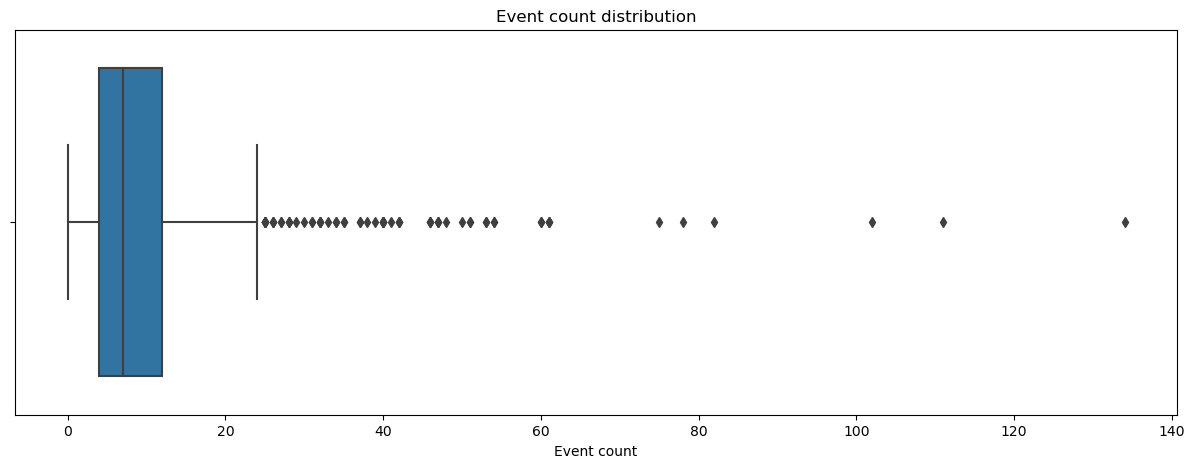

Event count: Count specific actions on the website, including page loads, link clicks, etc.


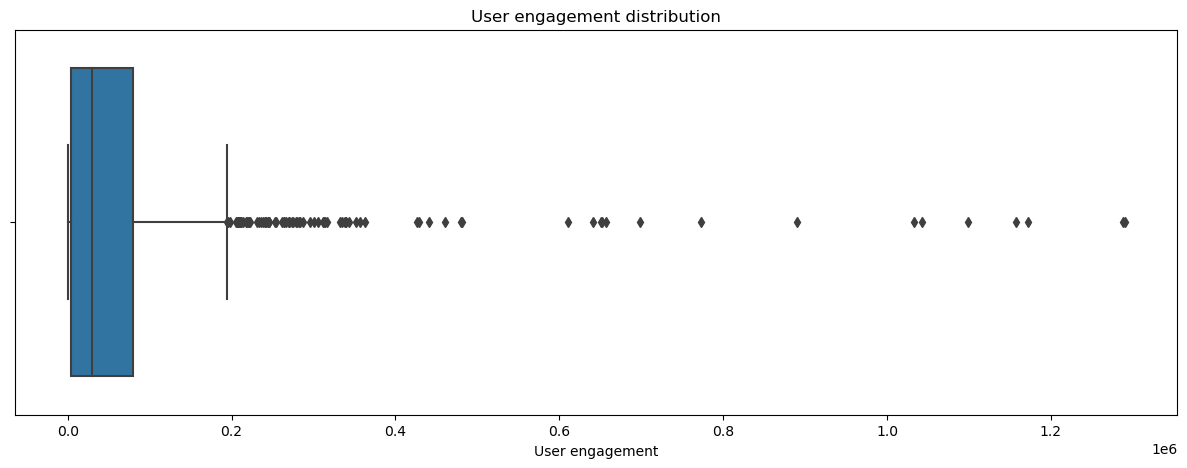

User engagement: The amount of time someone spends with the web page in focus.


In [8]:
for figure in box_plot_figure_title:
    plot_box_plot(figure_size, user_data, figure)
    
    if figure in figure_description:
        title = "".join([figure, ":"])
        description = " ".join([title, figure_description[figure]])
        print(description)

                Count Proportion
Guatemala         552     68.66%
United States     116     14.43%
Mexico             24      2.99%
Spain              15      1.87%
Colombia           12      1.49%
El Salvador        10      1.24%
China              10      1.24%
Taiwan              8       1.0%
Nicaragua           7      0.87%
France              6      0.75%
Honduras            5      0.62%
Ecuador             5      0.62%
Costa Rica          5      0.62%
Peru                4       0.5%
Panama              4       0.5%
Brazil              3      0.37%
Bolivia             2      0.25%
Liechtenstein       2      0.25%
Belgium             1      0.12%
Italy               1      0.12%
United Kingdom      1      0.12%
Switzerland         1      0.12%
Puerto Rico         1      0.12%
Paraguay            1      0.12%
India               1      0.12%
Togo                1      0.12%
Argentina           1      0.12%
Israel              1      0.12%
Portugal            1      0.12%
Indonesia 

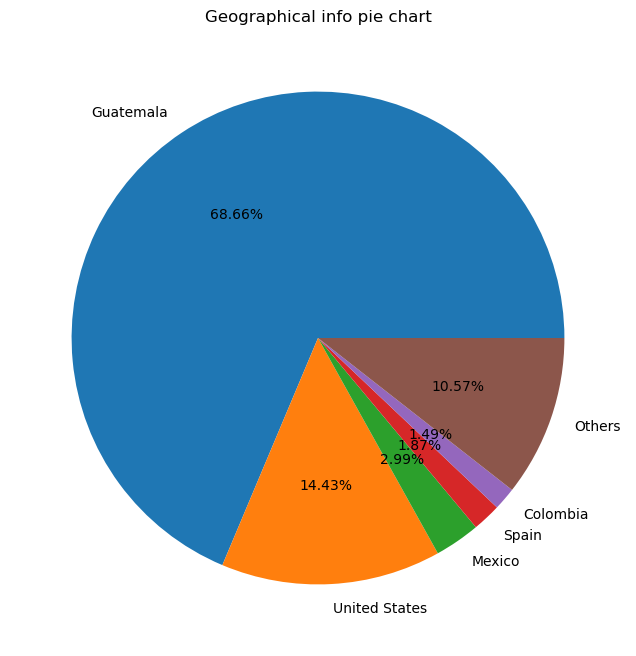

In [9]:
plot_pie_chart((8,8), user_data, "Geographical info", 5)

/Users/linjheyu/opt/anaconda3/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from current font.
  fig.canvas.draw()
/Users/linjheyu/opt/anaconda3/lib/python3.9/site-packages/seaborn/utils.py:660: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from current font.
  bboxes = [l.get_window_extent() for l in labels]
/Users/linjheyu/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


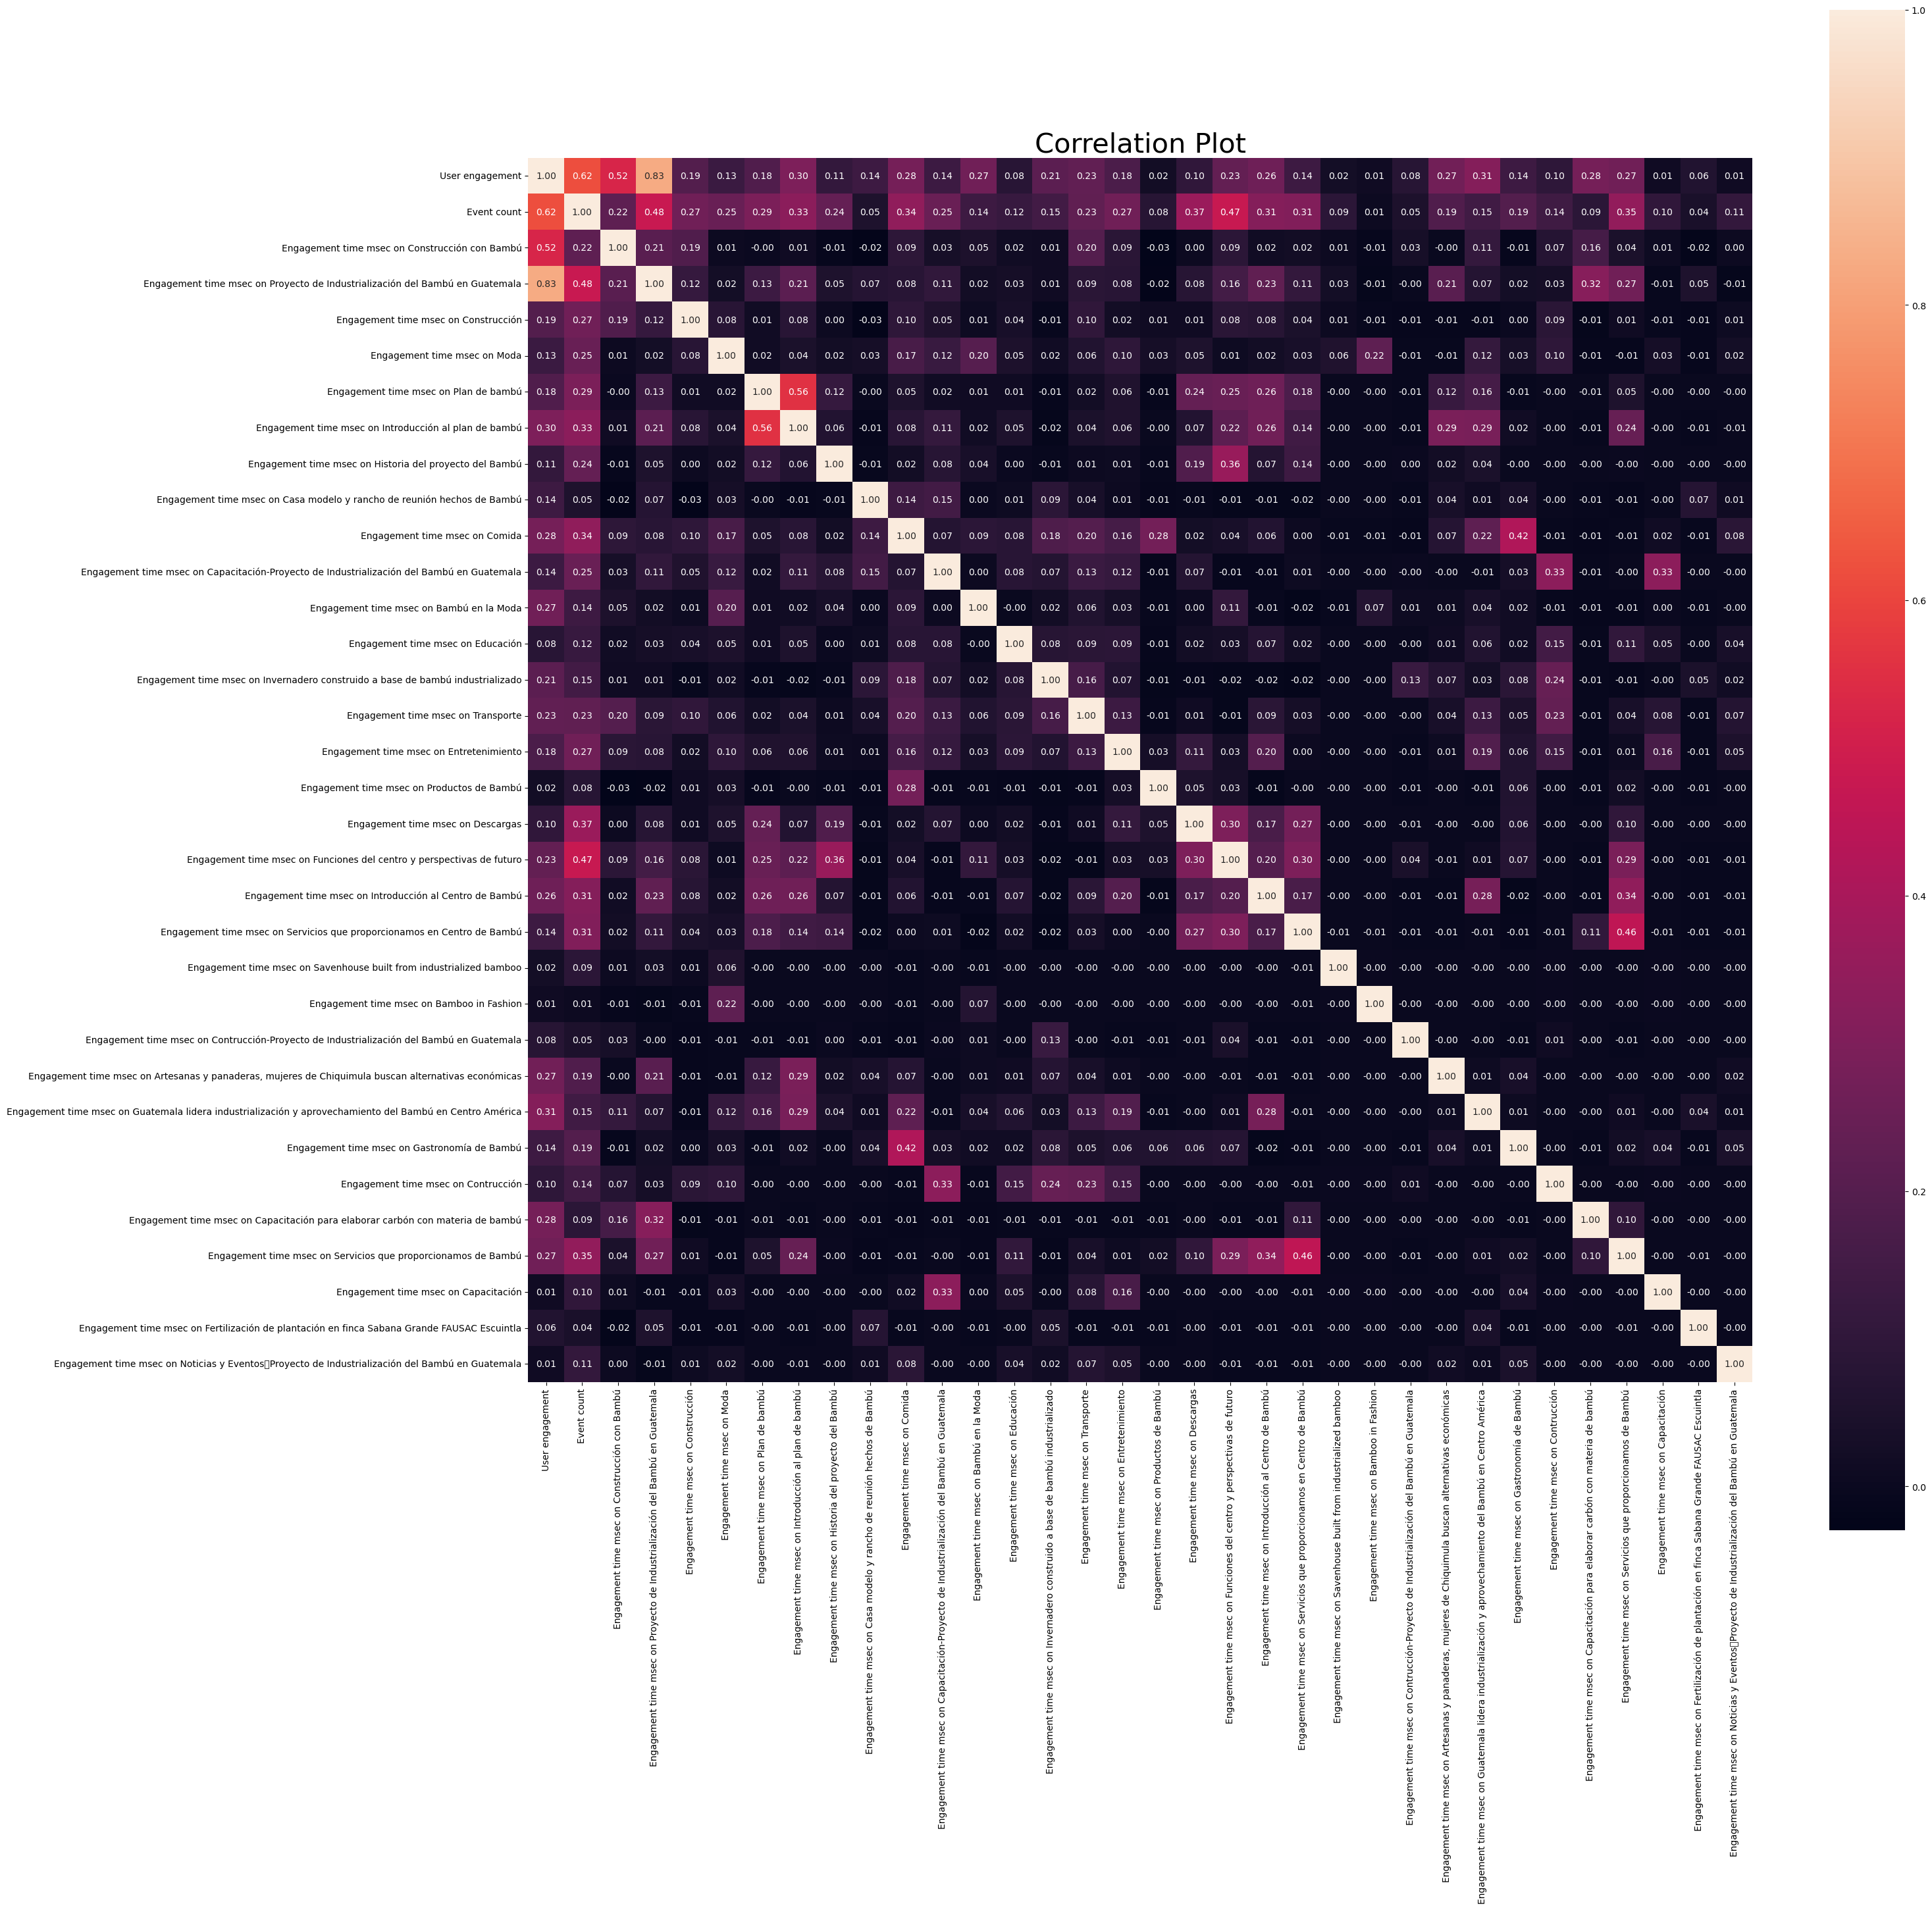

In [10]:
user_data = user_data.loc[:, (user_data != 0).any(axis = 0)]
user_data_filtered = user_data.drop(columns = columns_exclude)

plt.figure(figsize = (30,30))
ax = seaborn.heatmap(user_data_filtered.corr(), annot = True, square = True, fmt = ".2f")
plt.title("Correlation Plot", fontsize = 30)

plt.show()

In [11]:
print("Visitors with longer user engagement tend to engage in more events (r = 0.62).\n"
     "Visitors with longer user engagement tend to engage more on page {Construcción con Bambú} (r = 0.52).\n"
     "Visitors with longer user engagement tend to engage more on page {Proyecto de Industrialización del Bambú en Guatemala} (r = 0.83).\n"
     "Visitors with more event count tend to engage more on page {Introducción al plan de bambú} and {Plan de bambú} (r = 0.56).\n")


Visitors with longer user engagement tend to engage in more events (r = 0.62).
Visitors with longer user engagement tend to engage more on page {Construcción con Bambú} (r = 0.52).
Visitors with longer user engagement tend to engage more on page {Proyecto de Industrialización del Bambú en Guatemala} (r = 0.83).
Visitors with more event count tend to engage more on page {Introducción al plan de bambú} and {Plan de bambú} (r = 0.56).



In [12]:
columns_exclude.extend(["Geographical info", "Engagement page location", "Activity"])
user_data_filtered = user_data.drop(columns = columns_exclude)

user_data_filtered

,User engagement,Event count,Engagement time msec on Construcción con Bambú,Engagement time msec on Proyecto de Industrialización del Bambú en Guatemala,Engagement time msec on Construcción,Engagement time msec on Moda,Engagement time msec on Plan de bambú,Engagement time msec on Introducción al plan de bambú,Engagement time msec on Historia del proyecto del Bambú,Engagement time msec on Casa modelo y rancho de reunión hechos de Bambú,Engagement time msec on Comida,Engagement time msec on Capacitación-Proyecto de Industrialización del Bambú en Guatemala,Engagement time msec on Bambú en la Moda,Engagement time msec on Educación,Engagement time msec on Invernadero construido a base de bambú industrializado,Engagement time msec on Transporte,Engagement time msec on Entretenimiento,Engagement time msec on Productos de Bambú,Engagement time msec on Descargas,Engagement time msec on Funciones del centro y perspectivas de futuro,Engagement time msec on Introducción al Centro de Bambú,Engagement time msec on Servicios que proporcionamos en Centro de Bambú,Engagement time msec on Savenhouse built from industrialized bamboo,Engagement time msec on Bamboo in Fashion,Engagement time msec on Contrucción-Proyecto de Industrialización del Bambú en Guatemala,"Engagement time msec on Artesanas y panaderas, mujeres de Chiquimula buscan alternativas económicas",Engagement time msec on Guatemala lidera industrialización y aprovechamiento del Bambú en Centro América,Engagement time msec on Gastronomía de Bambú,Engagement time msec on Contrucción,Engagement time msec on Capacitación para elaborar carbón con materia de bambú,Engagement time msec on Servicios que proporcionamos de Bambú,Engagement time msec on Capacitación,Engagement time msec on Fertilización de plantación en finca Sabana Grande FAUSAC Escuintla,Engagement time msec on Noticias y Eventos｜Proyecto de Industrialización del Bambú en Guatemala
0,2380,4,2380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,18716,5,18716,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,26663,6,0,26663,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,175493,42,25642,109483,2686,6128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31554,0,0,0,0,0,0,0,0,0,0,0
4,33930,6,0,33930,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
800,125982,32,29634,75270,0,0,0,0,0,0,0,0,0,0,21078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
801,45907,13,15510,10045,6754,0,0,0,0,0,0,0,13598,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
802,4966,4,0,4966,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# standardization 
sc = StandardScaler()
user_data_standardized = sc.fit_transform(user_data_filtered)
user_data_standardized = pd.DataFrame(user_data_standardized)


user_data_standardized

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,-0.504402,-0.543842,-0.300177,-0.388710,-0.240998,-0.200033,-0.091002,-0.116739,-0.063581,-0.114739,-0.161768,-0.09503,-0.178996,-0.09168,-0.129430,-0.120237,-0.124802,-0.107837,-0.0821,-0.121730,-0.129318,-0.142593,-0.035289,-0.035289,-0.065366,-0.042268,-0.054748,-0.12208,-0.035289,-0.05922,-0.096824,-0.035289,-0.051933,-0.044654
1,-0.392290,-0.464501,0.035423,-0.388710,-0.240998,-0.200033,-0.091002,-0.116739,-0.063581,-0.114739,-0.161768,-0.09503,-0.178996,-0.09168,-0.129430,-0.120237,-0.124802,-0.107837,-0.0821,-0.121730,-0.129318,-0.142593,-0.035289,-0.035289,-0.065366,-0.042268,-0.054748,-0.12208,-0.035289,-0.05922,-0.096824,-0.035289,-0.051933,-0.044654
2,-0.337750,-0.385160,-0.349071,-0.114621,-0.240998,-0.200033,-0.091002,-0.116739,-0.063581,-0.114739,-0.161768,-0.09503,-0.178996,-0.09168,-0.129430,-0.120237,-0.124802,-0.107837,-0.0821,-0.121730,-0.129318,-0.142593,-0.035289,-0.035289,-0.065366,-0.042268,-0.054748,-0.12208,-0.035289,-0.05922,-0.096824,-0.035289,-0.051933,-0.044654
3,0.683652,2.471122,0.177709,0.736749,0.177922,1.669588,-0.091002,-0.116739,-0.063581,-0.114739,-0.161768,-0.09503,-0.178996,-0.09168,-0.129430,-0.120237,-0.124802,-0.107837,-0.0821,-0.121730,-0.129318,-0.142593,28.337255,-0.035289,-0.065366,-0.042268,-0.054748,-0.12208,-0.035289,-0.05922,-0.096824,-0.035289,-0.051933,-0.044654
4,-0.287878,-0.385160,-0.349071,-0.039918,-0.240998,-0.200033,-0.091002,-0.116739,-0.063581,-0.114739,-0.161768,-0.09503,-0.178996,-0.09168,-0.129430,-0.120237,-0.124802,-0.107837,-0.0821,-0.121730,-0.129318,-0.142593,-0.035289,-0.035289,-0.065366,-0.042268,-0.054748,-0.12208,-0.035289,-0.05922,-0.096824,-0.035289,-0.051933,-0.044654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,-0.520735,-0.623183,-0.349071,-0.388710,-0.240998,-0.200033,-0.091002,-0.116739,-0.063581,-0.114739,-0.161768,-0.09503,-0.178996,-0.09168,-0.129430,-0.120237,-0.124802,-0.107837,-0.0821,-0.121730,-0.129318,-0.142593,-0.035289,-0.035289,-0.065366,-0.042268,-0.054748,-0.12208,-0.035289,-0.05922,-0.096824,-0.035289,-0.051933,-0.044654
800,0.343864,1.677711,0.259719,0.385048,-0.240998,-0.200033,-0.091002,-0.116739,-0.063581,-0.114739,-0.161768,-0.09503,-0.178996,-0.09168,0.797004,-0.120237,-0.124802,-0.107837,-0.0821,-0.121730,-0.129318,-0.142593,-0.035289,-0.035289,-0.065366,-0.042268,-0.054748,-0.12208,-0.035289,-0.05922,-0.096824,-0.035289,-0.051933,-0.044654
801,-0.205681,0.170228,-0.030439,-0.285450,0.812384,-0.200033,-0.091002,-0.116739,-0.063581,-0.114739,-0.161768,-0.09503,0.263039,-0.09168,-0.129430,-0.120237,-0.124802,-0.107837,-0.0821,-0.121730,-0.129318,-0.142593,-0.035289,-0.035289,-0.065366,-0.042268,-0.054748,-0.12208,-0.035289,-0.05922,-0.096824,-0.035289,-0.051933,-0.044654
802,-0.486654,-0.543842,-0.349071,-0.337661,-0.240998,-0.200033,-0.091002,-0.116739,-0.063581,-0.114739,-0.161768,-0.09503,-0.178996,-0.09168,-0.129430,-0.120237,-0.124802,-0.107837,-0.0821,-0.121730,-0.129318,-0.142593,-0.035289,-0.035289,-0.065366,-0.042268,-0.054748,-0.12208,-0.035289,-0.05922,-0.096824,-0.035289,-0.051933,-0.044654


In [14]:
user_data_standardized_correlation = user_data_standardized.corr()

eigen_values, eigen_vectors = np.linalg.eig(user_data_standardized_correlation)
print("Eigenvectors \n{}\n".format(eigen_vectors))
print("Eigenvalues \n{} \n".format(eigen_values))

eigen_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
eigen_pairs.sort(key=lambda x: x[0], reverse=True)

print("Eigenvalues in descending order:")
for i in eigen_pairs:
    print(i[0])
print("\n")

Eigenvectors 
[[ 4.05138918e-01  1.52793201e-01 -7.67499780e-01 ... -4.75065825e-02
  -1.62091590e-02  8.35922964e-03]
 [ 4.18512169e-01  1.40245331e-02  1.32477227e-15 ... -7.82997954e-02
   2.80470626e-02 -7.11715338e-03]
 [ 1.68722612e-01  1.64378305e-01  2.56393797e-01 ...  1.45988236e-01
   1.37655789e-02 -3.60537032e-02]
 ...
 [ 3.93051443e-02  1.34888517e-01  3.45896377e-03 ...  1.68377609e-01
   1.17095829e-01  9.81303102e-03]
 [ 1.52289192e-02  2.61105525e-02  1.21683412e-02 ...  2.22849894e-01
   3.14042859e-01 -1.93451302e-03]
 [ 2.69856156e-02  7.35443189e-02  6.42044860e-03 ...  6.95276326e-02
  -2.35154412e-01  2.55775252e-01]]

Eigenvalues 
[ 4.19016185e+00  2.13918644e+00 -1.07497580e-16  1.71981000e+00
  2.13401105e-01  1.54921218e+00  1.48403874e+00  2.86301867e-01
  3.77596667e-01  4.37366672e-01  1.32813251e+00  1.29750979e+00
  4.86621509e-01  5.22389472e-01  5.42033195e-01  6.03183048e-01
  1.21806900e+00  1.17940050e+00  1.12218942e+00  6.80549059e-01
  7.2368304

Variance captured by each component is 
 [12.32400545304976, 6.291724813091068, 5.058264711890334, 4.556506401536138, 4.364819835034543, 3.906272073838707, 3.816205267248817, 3.5825558705965905, 3.4688249980840373, 3.300557108320381, 3.0854594137444926, 3.0254104977913006, 2.988075680941902, 2.899955120556302, 2.836657705431574, 2.7710185768411058, 2.706127934752992, 2.6685312731317645, 2.611759752826173, 2.5219936254460724, 2.4301060490083586, 2.266858235698977, 2.185587126232841, 2.1284795504658898, 2.0016148788003365, 1.7740677888566667, 1.5942152792949142, 1.5364396237101752, 1.4312397312602358, 1.2863725659696723, 1.1105784331752604, 0.8420643151441153, 0.6276503082285112, -3.161693519310014e-16]


Cumulative explained variance of 1 Component(s): 12.32%
Cumulative explained variance of 2 Component(s): 18.62%
Cumulative explained variance of 3 Component(s): 23.67%
Cumulative explained variance of 4 Component(s): 28.23%
Cumulative explained variance of 5 Component(s): 32.60%
Cumulat

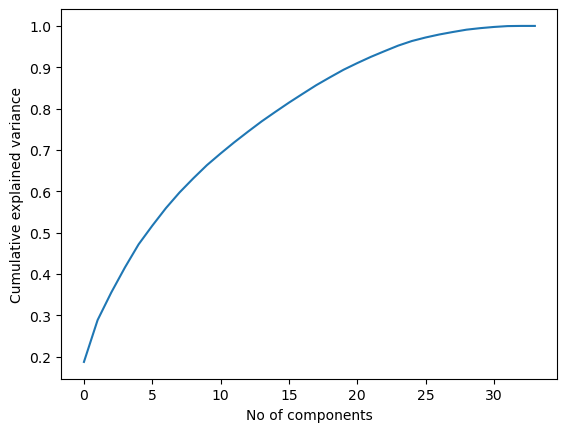

In [15]:
total = sum(eigen_values)
variance = [(i / total)*100 for i in sorted(eigen_values, reverse=True)]
cumulative_variance = np.cumsum(variance)
print("Variance captured by each component is \n",variance)
print("\n")

count = 1
for variance in cumulative_variance:
    print("Cumulative explained variance of {} Component(s): {:.2f}%".format(count, variance))
    count += 1


pca = PCA().fit(user_data_standardized_correlation)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("No of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [16]:
print("Data before PCA\n")
user_data_filtered.head()

Data before PCA



,User engagement,Event count,Engagement time msec on Construcción con Bambú,Engagement time msec on Proyecto de Industrialización del Bambú en Guatemala,Engagement time msec on Construcción,Engagement time msec on Moda,Engagement time msec on Plan de bambú,Engagement time msec on Introducción al plan de bambú,Engagement time msec on Historia del proyecto del Bambú,Engagement time msec on Casa modelo y rancho de reunión hechos de Bambú,Engagement time msec on Comida,Engagement time msec on Capacitación-Proyecto de Industrialización del Bambú en Guatemala,Engagement time msec on Bambú en la Moda,Engagement time msec on Educación,Engagement time msec on Invernadero construido a base de bambú industrializado,Engagement time msec on Transporte,Engagement time msec on Entretenimiento,Engagement time msec on Productos de Bambú,Engagement time msec on Descargas,Engagement time msec on Funciones del centro y perspectivas de futuro,Engagement time msec on Introducción al Centro de Bambú,Engagement time msec on Servicios que proporcionamos en Centro de Bambú,Engagement time msec on Savenhouse built from industrialized bamboo,Engagement time msec on Bamboo in Fashion,Engagement time msec on Contrucción-Proyecto de Industrialización del Bambú en Guatemala,"Engagement time msec on Artesanas y panaderas, mujeres de Chiquimula buscan alternativas económicas",Engagement time msec on Guatemala lidera industrialización y aprovechamiento del Bambú en Centro América,Engagement time msec on Gastronomía de Bambú,Engagement time msec on Contrucción,Engagement time msec on Capacitación para elaborar carbón con materia de bambú,Engagement time msec on Servicios que proporcionamos de Bambú,Engagement time msec on Capacitación,Engagement time msec on Fertilización de plantación en finca Sabana Grande FAUSAC Escuintla,Engagement time msec on Noticias y Eventos｜Proyecto de Industrialización del Bambú en Guatemala
0,2380,4,2380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,18716,5,18716,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,26663,6,0,26663,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,175493,42,25642,109483,2686,6128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31554,0,0,0,0,0,0,0,0,0,0,0
4,33930,6,0,33930,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
# PCA
number_of_columns = 17
user_data_standardized_2D = PCA(n_components = number_of_columns).fit_transform(user_data_standardized)
user_data_standardized_2D = pd.DataFrame(user_data_standardized_2D)

rename_columns = {}
for i in range(number_of_columns):
    number = str(i+1)
    rename_columns[i] = "PCA" + number
    
user_data_standardized_2D = user_data_standardized_2D.rename(columns = rename_columns)

print("PCA\n")
user_data_standardized_2D

PCA



,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17
0,-0.982643,-0.243852,-0.133956,0.058795,0.184640,-0.112966,-0.024637,-0.002450,0.017758,0.025347,0.063110,0.006629,-0.032504,-0.092479,-0.065302,-0.031785,-0.042542
1,-0.847398,-0.170135,-0.000234,0.017594,0.152617,-0.059285,-0.074139,-0.035328,-0.102992,0.034382,0.061067,0.018104,-0.050880,-0.088552,-0.064117,-0.049112,-0.033856
2,-0.772425,-0.219784,0.000209,0.043617,0.157455,-0.124674,0.040121,0.044562,0.035325,0.030183,0.057754,0.009549,-0.001593,-0.101539,-0.050438,-0.004804,-0.042152
3,1.883770,0.778441,0.496060,-0.733570,-1.359490,3.991801,1.102719,1.759924,0.964752,-3.573604,-5.802610,4.767432,24.642406,-0.464620,-8.833577,-0.539499,-0.174526
4,-0.729179,-0.210936,0.047156,0.041653,0.154290,-0.126053,0.053004,0.056099,0.036769,0.034712,0.057839,0.007816,0.001550,-0.105946,-0.049279,0.000487,-0.039720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,-1.030715,-0.255524,-0.146031,0.070362,0.197364,-0.121252,-0.021517,0.002383,0.037469,0.028198,0.065782,0.000598,-0.036478,-0.096110,-0.069769,-0.031268,-0.040914
800,0.699348,0.262102,0.339219,-0.244125,-0.125125,-0.198581,0.257649,-0.298687,-0.001017,0.078838,0.125823,0.137554,0.226998,-0.165132,0.007791,0.041873,-0.192745
801,-0.320841,-0.015215,0.064580,-0.106990,-0.054962,0.273709,-0.080322,-0.188404,-0.363483,-0.364400,-0.262797,-0.055803,-0.087034,0.365401,0.088806,0.082312,-0.075533
802,-0.967956,-0.248386,-0.122619,0.062507,0.185769,-0.121649,-0.007924,0.010216,0.035975,0.026416,0.063061,0.004517,-0.026546,-0.095541,-0.063950,-0.025302,-0.042639


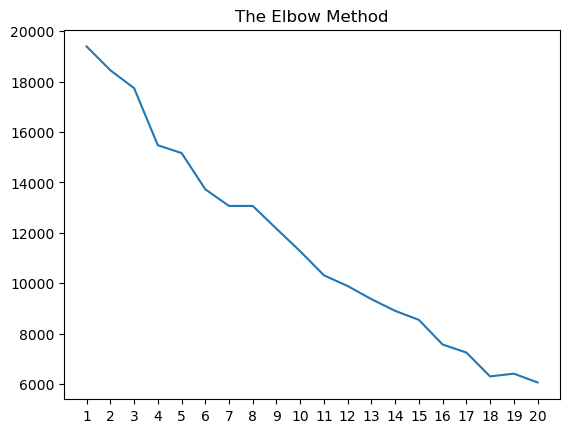

In [18]:
clusters = range(1, 21)
inertias = []

for k in clusters:
    kmeans = KMeans(n_init = 1, n_clusters = k)
    fitted_model = kmeans.fit(user_data_standardized_2D)
    inertias.append(fitted_model.inertia_)
    
ax = seaborn.lineplot(x = range(1,21), y = inertias)
ax.set_title('The Elbow Method')
plt.xticks(range(1, 21))

plt.show()

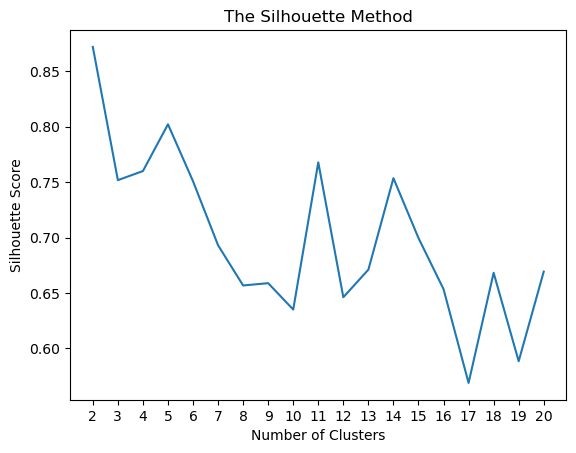

In [19]:
silhouette = []

for k in range(2, 21): 
    kmeans = KMeans(n_init = 1, n_clusters = k)
    labels = kmeans.fit_predict(user_data_standardized_2D)  
    silhouette.append(silhouette_score(user_data_standardized_2D, labels, metric = 'euclidean'))

ax = seaborn.lineplot(x = range(2, 21), y = silhouette)
ax.set_title('The Silhouette Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 21))

plt.show()

In [20]:
kmeans = KMeans(n_init = 1, n_clusters = 2)
labels = kmeans.fit_predict(user_data_standardized_2D)
user_data_standardized_2D["Clusters"] = labels



user_data_standardized_2D

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,Clusters
0,-0.982643,-0.243852,-0.133956,0.058795,0.184640,-0.112966,-0.024637,-0.002450,0.017758,0.025347,0.063110,0.006629,-0.032504,-0.092479,-0.065302,-0.031785,-0.042542,0
1,-0.847398,-0.170135,-0.000234,0.017594,0.152617,-0.059285,-0.074139,-0.035328,-0.102992,0.034382,0.061067,0.018104,-0.050880,-0.088552,-0.064117,-0.049112,-0.033856,0
2,-0.772425,-0.219784,0.000209,0.043617,0.157455,-0.124674,0.040121,0.044562,0.035325,0.030183,0.057754,0.009549,-0.001593,-0.101539,-0.050438,-0.004804,-0.042152,0
3,1.883770,0.778441,0.496060,-0.733570,-1.359490,3.991801,1.102719,1.759924,0.964752,-3.573604,-5.802610,4.767432,24.642406,-0.464620,-8.833577,-0.539499,-0.174526,0
4,-0.729179,-0.210936,0.047156,0.041653,0.154290,-0.126053,0.053004,0.056099,0.036769,0.034712,0.057839,0.007816,0.001550,-0.105946,-0.049279,0.000487,-0.039720,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,-1.030715,-0.255524,-0.146031,0.070362,0.197364,-0.121252,-0.021517,0.002383,0.037469,0.028198,0.065782,0.000598,-0.036478,-0.096110,-0.069769,-0.031268,-0.040914,0
800,0.699348,0.262102,0.339219,-0.244125,-0.125125,-0.198581,0.257649,-0.298687,-0.001017,0.078838,0.125823,0.137554,0.226998,-0.165132,0.007791,0.041873,-0.192745,0
801,-0.320841,-0.015215,0.064580,-0.106990,-0.054962,0.273709,-0.080322,-0.188404,-0.363483,-0.364400,-0.262797,-0.055803,-0.087034,0.365401,0.088806,0.082312,-0.075533,0
802,-0.967956,-0.248386,-0.122619,0.062507,0.185769,-0.121649,-0.007924,0.010216,0.035975,0.026416,0.063061,0.004517,-0.026546,-0.095541,-0.063950,-0.025302,-0.042639,0


In [21]:
# Copy the "Clusters" column from user_data_standardized_2D
Clusters = user_data_standardized_2D["Clusters"].copy()

# Prefix each value with "Cluster"
Clusters = "Cluster" + Clusters.astype(str)

print(Clusters)


0      Cluster0
1      Cluster0
2      Cluster0
3      Cluster0
4      Cluster0
         ...   
799    Cluster0
800    Cluster0
801    Cluster0
802    Cluster0
803    Cluster1
Name: Clusters, Length: 804, dtype: object


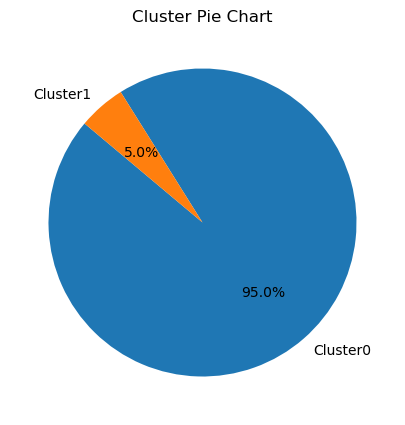

cluster 0: 764
cluster 1: 40


In [22]:
# Generate the pie chart
plt.figure(figsize=figure_size)
counts = Clusters.value_counts()
pie = counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)
plt.title('Cluster Pie Chart')
plt.ylabel("")

# Create custom labels for the legend with the prefix "Cluster"
cluster_labels = ["Cluster " + str(label) for label in counts.index]

plt.show()


print("cluster 0: {}".format((user_data_standardized_2D["Clusters"] == 0).sum()))
print("cluster 1: {}".format((user_data_standardized_2D["Clusters"] == 1).sum()))

In [23]:
number_of_total_columns = len(user_data_filtered.columns)

rename_total_columns = {}
for i in range(number_of_total_columns):
    number = str(i+1)
    rename_total_columns[i] = "PCA" + number

formated_pca_data = pd.DataFrame(pca.components_, columns = user_data_filtered.columns).round(2).T
formated_pca_data = formated_pca_data.rename(columns = rename_total_columns)

formated_pca_data

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18,PCA19,PCA20,PCA21,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,PCA30,PCA31,PCA32,PCA33,PCA34
User engagement,0.35,0.38,0.15,-0.07,-0.04,0.04,0.08,-0.01,-0.00,-0.10,0.03,-0.01,0.02,-0.01,0.04,0.03,0.03,-0.04,0.03,-0.02,-0.04,0.08,0.03,-0.01,0.10,-0.05,-0.05,-0.15,-0.12,-0.03,-0.02,0.03,0.14,0.77
Event count,0.35,0.10,-0.16,0.14,-0.18,0.02,0.10,0.01,-0.04,0.05,-0.04,0.04,0.11,-0.05,-0.08,0.15,0.07,-0.06,-0.03,-0.07,-0.10,0.00,0.07,0.02,-0.09,-0.04,0.09,0.08,0.13,0.07,0.31,-0.20,-0.72,-0.00
Engagement time msec on Construcción con Bambú,0.14,0.32,0.21,0.07,-0.07,0.17,-0.11,-0.11,0.33,0.08,-0.01,-0.02,-0.12,-0.03,-0.02,-0.13,-0.09,0.14,0.10,0.15,-0.29,0.24,-0.04,-0.40,0.13,0.24,-0.26,0.15,0.09,0.02,0.13,0.03,0.05,-0.26
Engagement time msec on Proyecto de Industrialización del Bambú en Guatemala,0.36,0.28,0.27,-0.01,0.01,-0.06,0.12,0.17,-0.06,-0.04,-0.02,-0.00,0.08,0.08,-0.03,0.12,0.17,-0.07,0.01,-0.11,0.04,0.10,0.00,0.22,-0.01,-0.08,-0.03,-0.31,-0.23,-0.06,-0.30,0.15,-0.01,-0.51
Engagement time msec on Construcción,0.08,0.13,0.01,0.11,-0.09,0.16,-0.05,-0.13,0.15,0.47,-0.35,-0.15,-0.18,-0.30,-0.11,0.08,0.23,0.08,-0.02,0.07,0.28,-0.30,0.16,0.06,-0.00,-0.18,0.11,-0.01,-0.04,0.04,0.09,-0.09,0.21,-0.03
Engagement time msec on Moda,-0.03,0.08,-0.16,0.00,-0.09,0.49,0.07,0.11,-0.34,-0.00,-0.04,-0.03,0.09,0.03,-0.11,0.04,0.11,-0.08,-0.23,-0.10,-0.26,-0.33,-0.04,-0.04,-0.08,0.50,-0.05,-0.00,-0.13,-0.06,-0.03,0.02,0.13,-0.02
Engagement time msec on Plan de bambú,0.26,-0.19,-0.21,-0.15,0.28,-0.00,0.17,-0.07,0.07,0.10,0.01,-0.05,-0.06,0.11,-0.13,-0.11,-0.08,0.05,-0.26,0.23,-0.05,0.20,0.20,0.06,-0.25,0.06,-0.25,-0.24,0.04,0.06,-0.08,-0.47,0.13,-0.01
Engagement time msec on Introducción al plan de bambú,0.30,-0.08,-0.18,-0.21,0.37,-0.04,0.14,0.01,-0.07,0.20,0.03,-0.06,-0.09,-0.07,0.02,-0.07,-0.08,0.04,-0.18,-0.06,-0.01,0.07,-0.00,-0.12,-0.12,-0.08,0.07,0.30,-0.22,0.08,0.18,0.58,-0.01,-0.02
Engagement time msec on Historia del proyecto del Bambú,0.12,-0.20,-0.08,0.12,-0.16,0.08,0.30,-0.16,0.27,-0.19,-0.06,0.10,-0.01,0.22,0.25,-0.15,0.12,0.12,0.18,-0.43,0.08,-0.19,-0.01,0.05,-0.08,-0.05,-0.32,0.03,-0.15,0.21,0.18,-0.00,0.13,-0.04
Engagement time msec on Casa modelo y rancho de reunión hechos de Bambú,-0.05,0.10,0.01,-0.05,-0.01,-0.21,0.20,0.12,-0.18,-0.34,-0.40,0.03,-0.03,-0.18,-0.11,-0.47,0.23,-0.20,0.17,0.23,0.00,0.04,-0.01,-0.09,-0.16,0.07,0.11,-0.07,0.03,0.07,0.24,0.02,0.08,-0.05


/Users/linjheyu/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


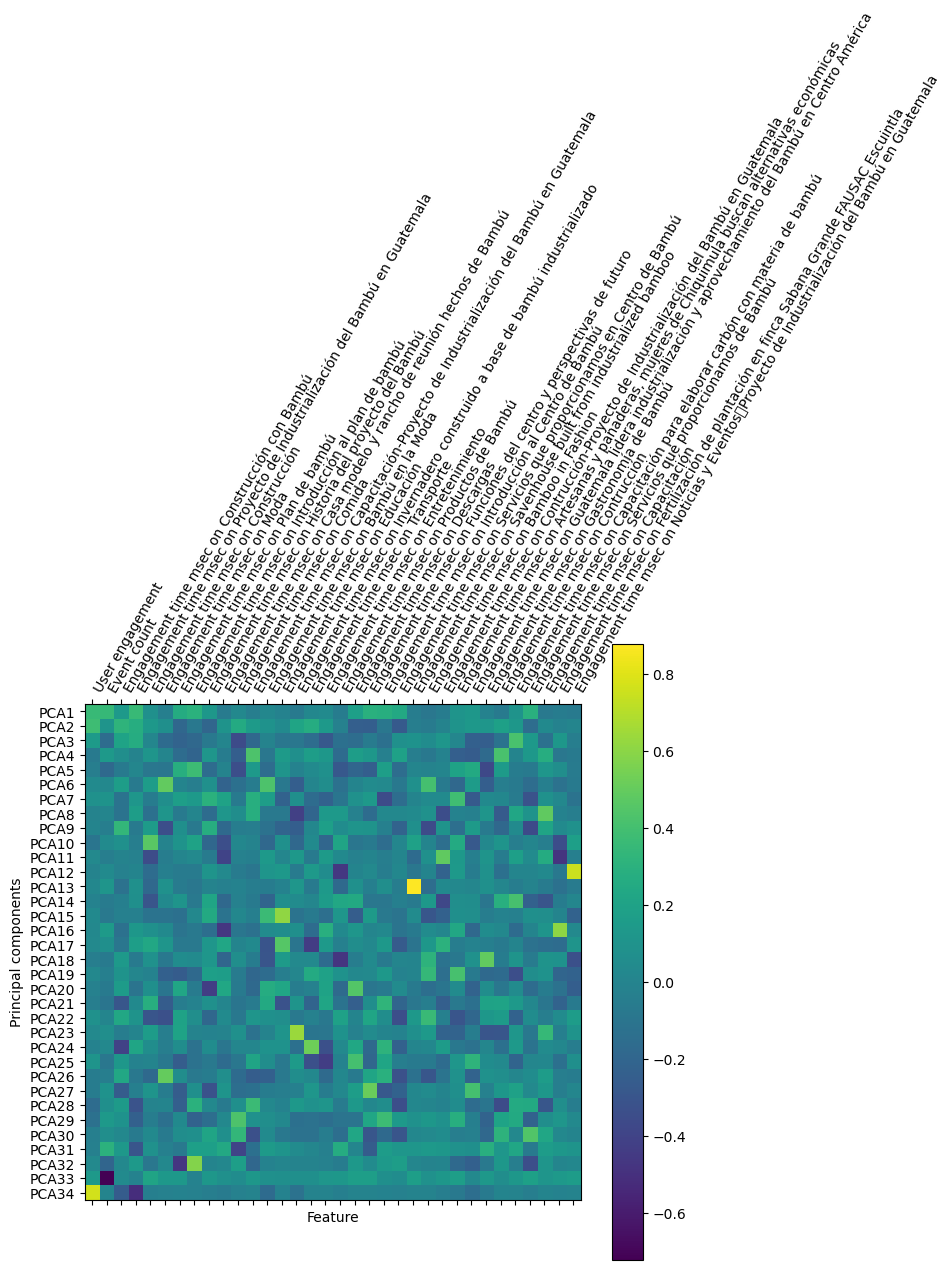

In [24]:
fig, ax = plt.subplots(figsize = (8, 8))
mat = ax.matshow(pca.components_)

color_bar = fig.colorbar(mat)

plt.yticks(range(number_of_total_columns), ["PCA" + str(i+1) for i in range(number_of_total_columns)])
plt.xticks(range(len(user_data_filtered.columns)), user_data_filtered.columns, rotation=60, ha='left')

plt.xlabel("Feature")
plt.ylabel("Principal components")

plt.show()

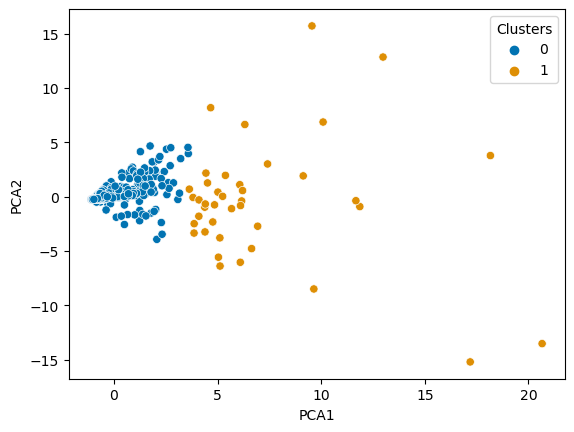

In [25]:
seaborn.scatterplot(data = user_data_standardized_2D, x = "PCA1", y = "PCA2", hue = "Clusters", palette = "colorblind")

plt.show()

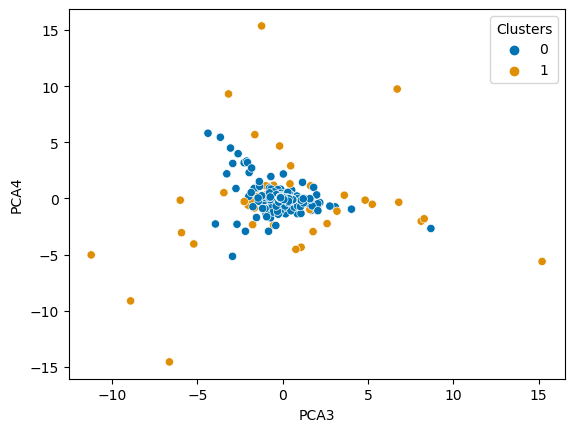

In [26]:
seaborn.scatterplot(data = user_data_standardized_2D, x = "PCA3", y = "PCA4", hue = "Clusters", palette = "colorblind")

plt.show()

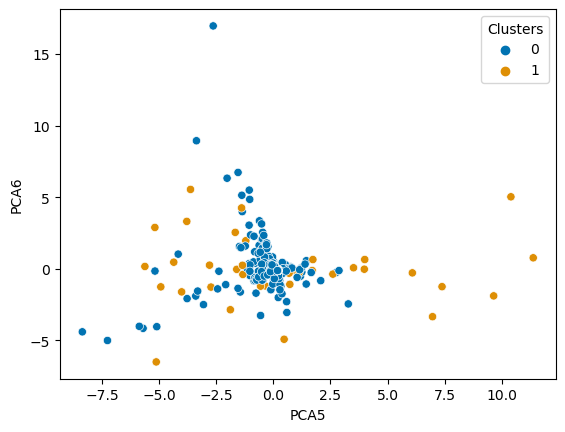

In [27]:
seaborn.scatterplot(data = user_data_standardized_2D, x = "PCA5", y = "PCA6", hue = "Clusters", palette = "colorblind")

plt.show()

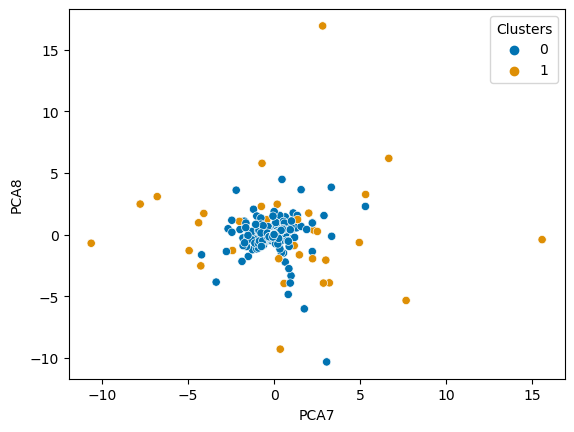

In [28]:
seaborn.scatterplot(data = user_data_standardized_2D, x = "PCA7", y = "PCA8", hue = "Clusters", palette = "colorblind")

plt.show()

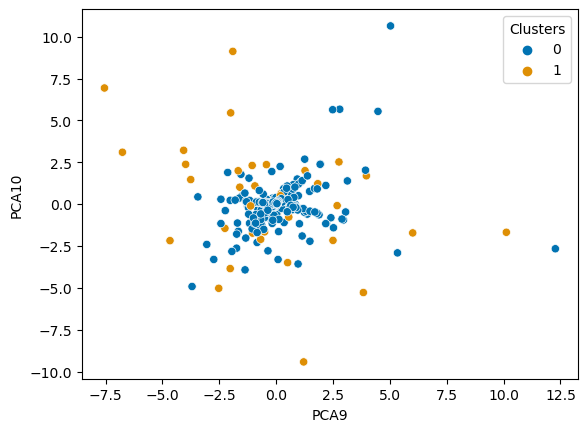

In [29]:
seaborn.scatterplot(data = user_data_standardized_2D, x = "PCA9", y = "PCA10", hue = "Clusters", palette = "colorblind")

plt.show()

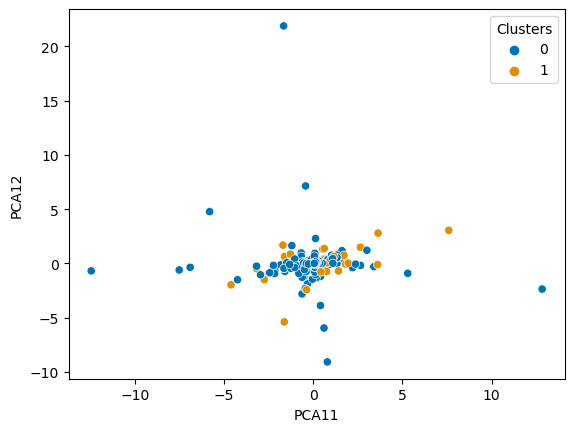

In [30]:
seaborn.scatterplot(data = user_data_standardized_2D, x = "PCA11", y = "PCA12", hue = "Clusters", palette = "colorblind")

plt.show()

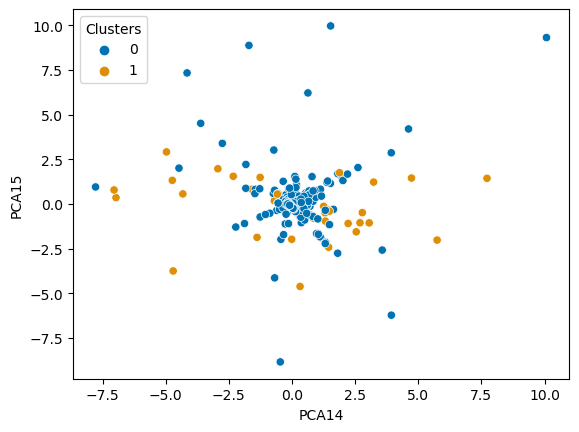

In [31]:
seaborn.scatterplot(data = user_data_standardized_2D, x = "PCA14", y = "PCA15", hue = "Clusters", palette = "colorblind")

plt.show()

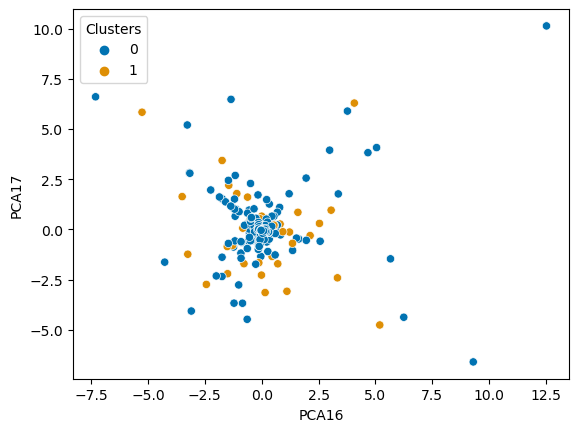

In [32]:
seaborn.scatterplot(data = user_data_standardized_2D, x = "PCA16", y = "PCA17", hue = "Clusters", palette = "colorblind")

plt.show()

In [33]:
user_data_filtered["Clusters"] = labels
group = user_data_filtered.groupby("Clusters")

group.aggregate(["mean", "median", "std"]).T

Clusters                                                              0  \
User engagement                                    mean    53440.261780   
                                                   median  26010.000000   
                                                   std     75568.382719   
Event count                                        mean        9.037958   
                                                   median      6.000000   
                                                   std         7.913349   
Engagement time msec on Construcción con Bambú     mean    14443.273560   
                                                   median      0.000000   
                                                   std     40111.842743   
Engagement time msec on Proyecto de Industriali... mean    24516.763089   
                                                   median      0.000000   
                                                   std     49772.165225   
Engagement time msec on Construcción               mean     1315.848168   
                                                   median      0.000000   
                                                   std      5639.839123   
Engagement time msec on Moda                       mean      584.755236   
                                                   median      0.000000   
                                                   std      3220.687419   
Engagement time msec on Plan de bambú              mean       25.476440   
                                                   median      0.000000   
                                                   std       421.397203   
Engagement time msec on Introducción al plan de... mean       10.992147   
                                                   median      0.000000   
                                                   std       303.828977   
Engagement time msec on Historia del proyecto d... mean       31.549738   
                                                   median      0.000000   
                                                   std       872.052114   
Engagement time msec on Casa modelo y rancho de... mean     1005.982984   
                                                   median      0.000000   
                                                   std      9453.786930   
Engagement time msec on Comida                     mean      456.581152   
                                                   median      0.000000   
                                                   std      3208.672189   
Engagement time msec on Capacitación-Proyecto d... mean       59.227749   
                                                   median      0.000000   
                                                   std       894.740952   
Engagement time msec on Bambú en la Moda           mean     4604.697644   
                                                   median      0.000000   
                                                   std     28814.814469   
Engagement time msec on Educación                  mean      154.273560   
                                                   median      0.000000   
                                                   std      2012.766394   
Engagement time msec on Invernadero construido ... mean     2528.937173   
                                                   median      0.000000   
                                                   std     20370.103743   
Engagement time msec on Transporte                 mean      124.767016   
                                                   median      0.000000   
                                                   std      1474.407069   
Engagement time msec on Entretenimiento            mean       87.352094   
                                                   median      0.000000   
                                                   std       812.590034   
Engagement time msec on Productos de Bambú         mean      583.674084   
                         

In [34]:
cluster_0_summary = group.get_group(0)
cluster_0_summary = cluster_0_summary.mean()
cluster_0_summary = pd.DataFrame(cluster_0_summary.sort_values(ascending = False))
cluster_0_rank = cluster_0_summary.index.tolist()

user_engagement_value = cluster_0_summary.loc["User engagement"]
cluster_0_summary = round(cluster_0_summary / user_engagement_value * 100, 2)
cluster_0_summary = cluster_0_summary.astype(str) + "%"

cluster_1_summary = group.get_group(1)
cluster_1_summary = cluster_1_summary.mean()
cluster_1_summary = pd.DataFrame(cluster_1_summary.sort_values(ascending = False))
cluster_1_rank = cluster_1_summary.index.tolist()

user_engagement_value = cluster_1_summary.loc["User engagement"]
cluster_1_summary = round(cluster_1_summary / user_engagement_value * 100, 2)
cluster_1_summary = cluster_1_summary.astype(str) + "%"

remove_list = ["User engagement", "Clusters", "Event count"]

for value_to_remove in remove_list:
    cluster_0_rank.remove(value_to_remove)
    cluster_1_rank.remove(value_to_remove)
    cluster_0_summary = cluster_0_summary.drop(value_to_remove)
    cluster_1_summary = cluster_1_summary.drop(value_to_remove)

print()
for i in range(len(cluster_0_rank)):
    cluster_0_rank[i] = cluster_0_rank[i].removeprefix("Engagement time msec on ")
    cluster_1_rank[i] = cluster_1_rank[i].removeprefix("Engagement time msec on ")

pd.options.display.max_colwidth = 100
    
cluster_0_summary = cluster_0_summary.reset_index(drop=True)
cluster_1_summary = cluster_1_summary.reset_index(drop=True) 

topic_ranking = pd.DataFrame({"Cluster 0": cluster_0_rank, "Time proportion ":cluster_0_summary.iloc[:,0], "Cluster 1": cluster_1_rank, "Time proportion": cluster_1_summary.iloc[:,0]})
topic_ranking.index.name = 'Ranking'
topic_ranking.index = topic_ranking.index + 1


topic_ranking

,Cluster 0,Time proportion,Cluster 1,Time proportion
Ranking,,,,
1,Proyecto de Industrialización del Bambú en Guatemala,45.88%,Proyecto de Industrialización del Bambú en Guatemala,57.84%
2,Construcción con Bambú,27.03%,Construcción con Bambú,13.02%
3,Bambú en la Moda,8.62%,Bambú en la Moda,4.51%
4,Invernadero construido a base de bambú industrializado,4.73%,Guatemala lidera industrialización y aprovechamiento del Bambú en Centro América,4.45%
5,Construcción,2.46%,"Artesanas y panaderas, mujeres de Chiquimula buscan alternativas económicas",2.37%
6,Gastronomía de Bambú,2.18%,Servicios que proporcionamos de Bambú,2.28%
7,Casa modelo y rancho de reunión hechos de Bambú,1.88%,Invernadero construido a base de bambú industrializado,2.16%
8,Moda,1.09%,Historia del proyecto del Bambú,1.64%
9,Productos de Bambú,1.09%,Gastronomía de Bambú,1.51%


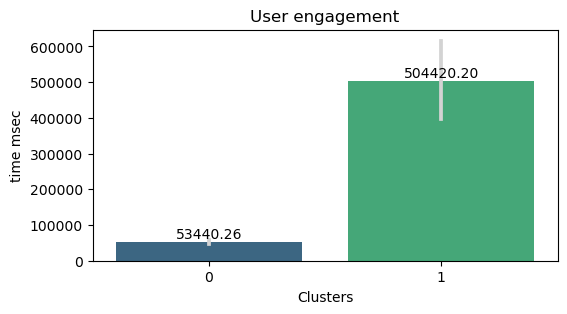

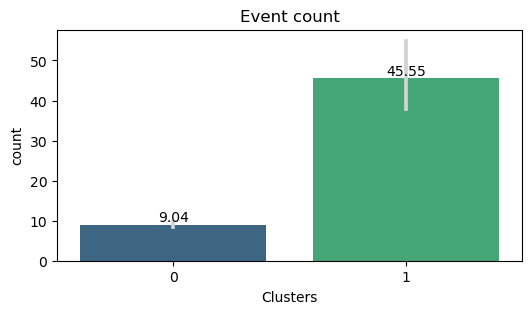

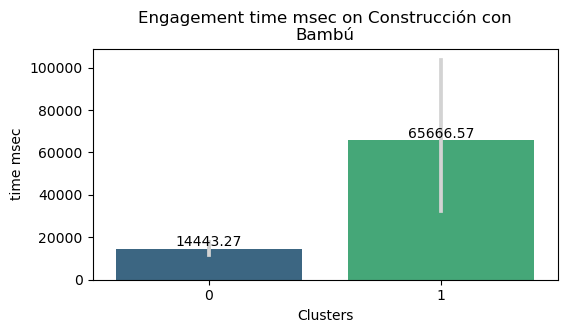

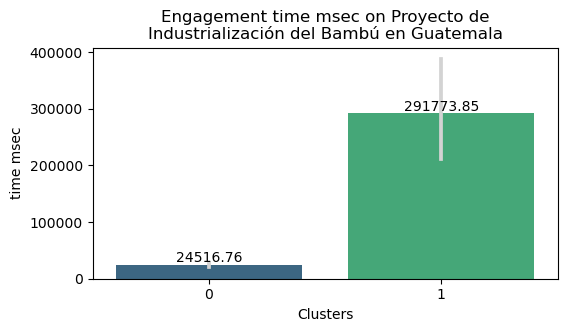

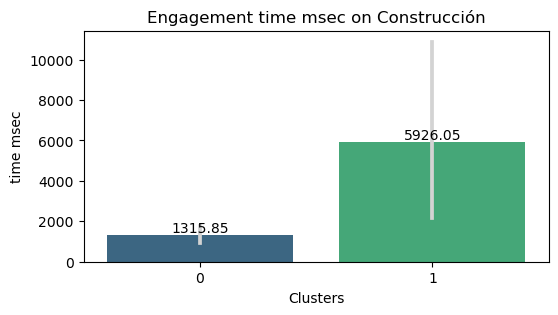

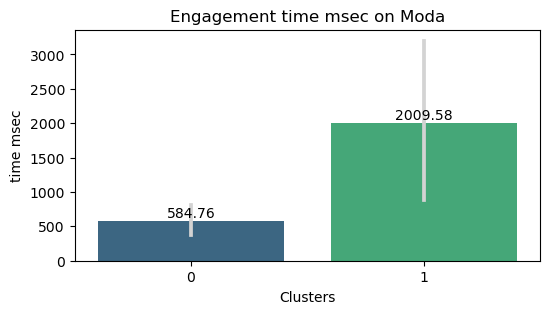

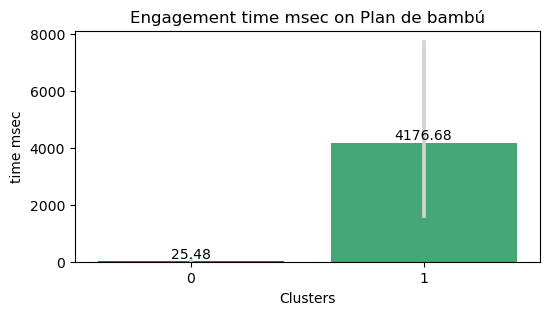

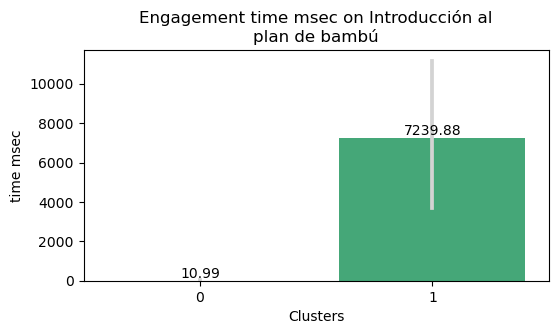

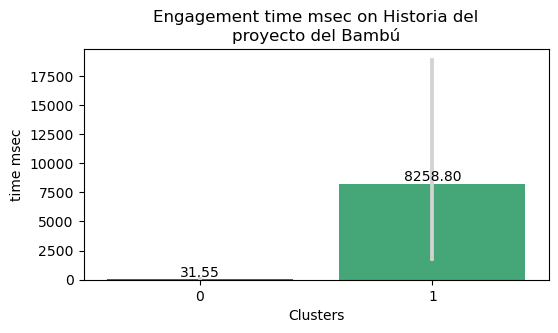

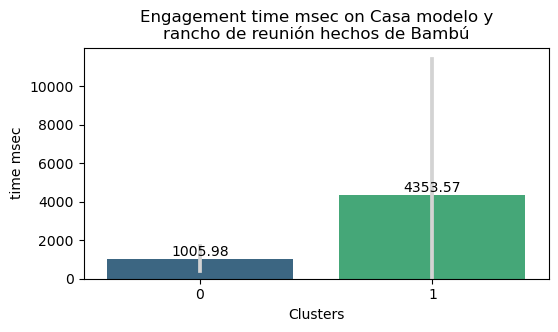

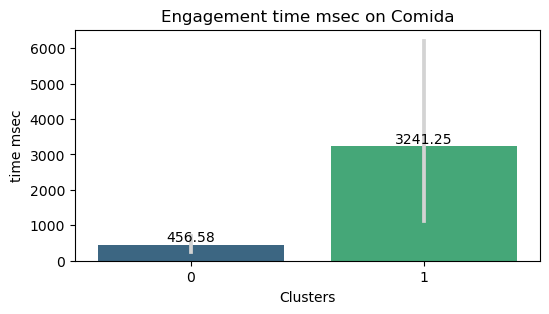

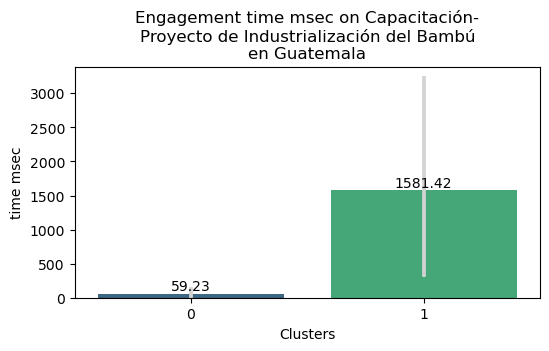

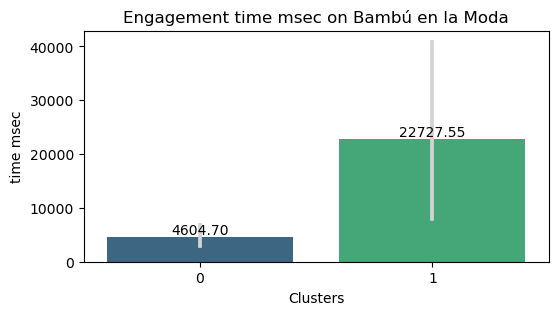

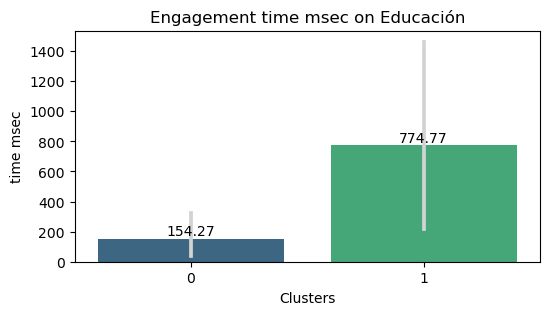

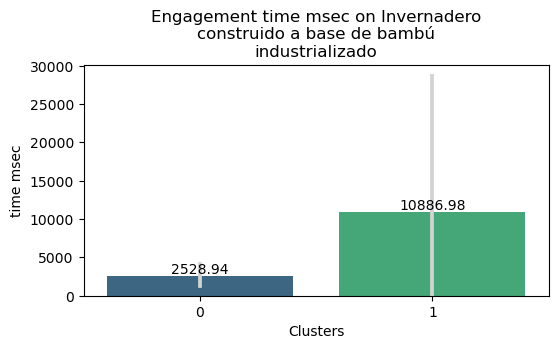

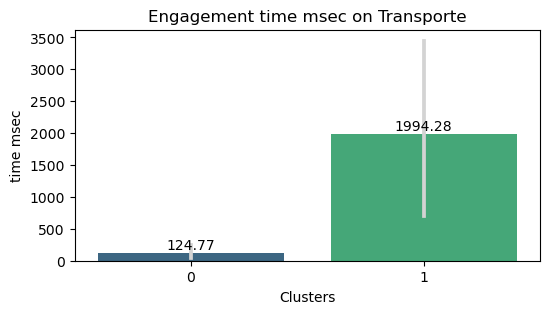

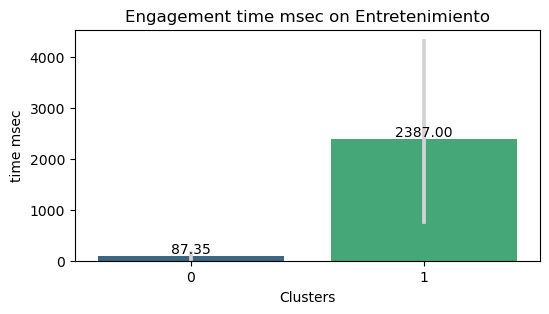

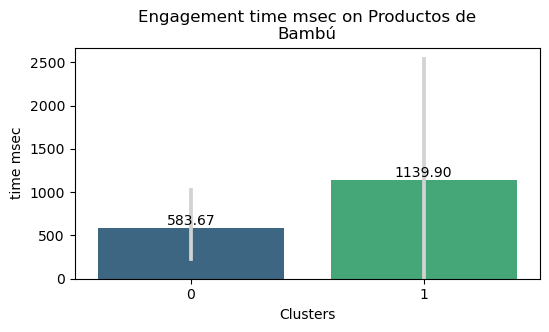

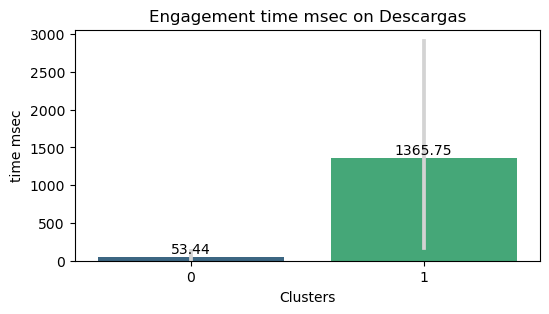

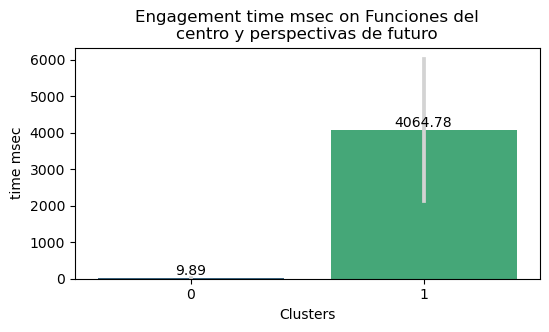

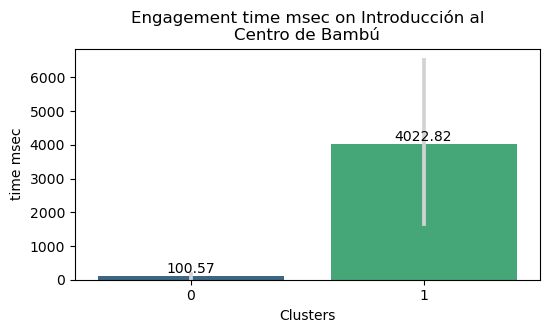

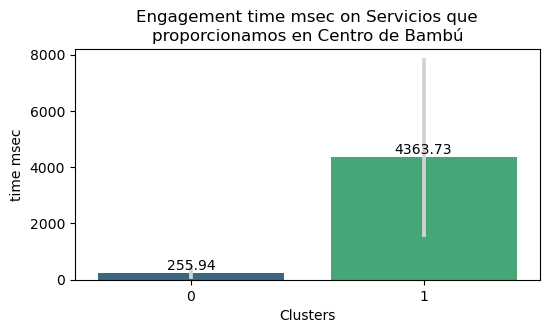

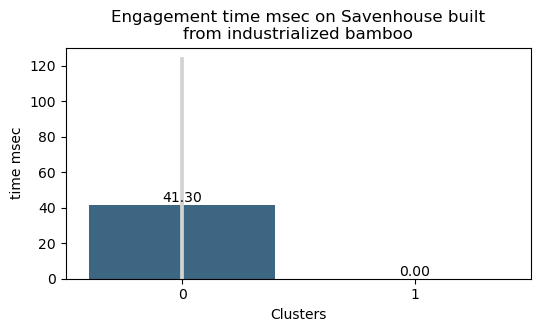

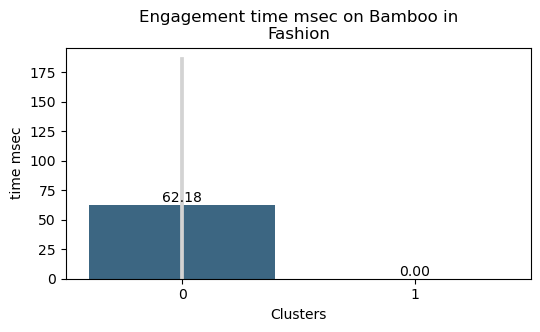

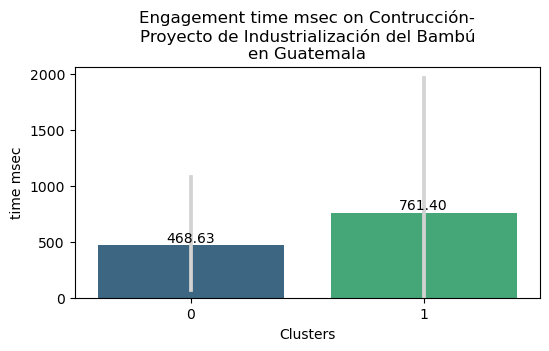

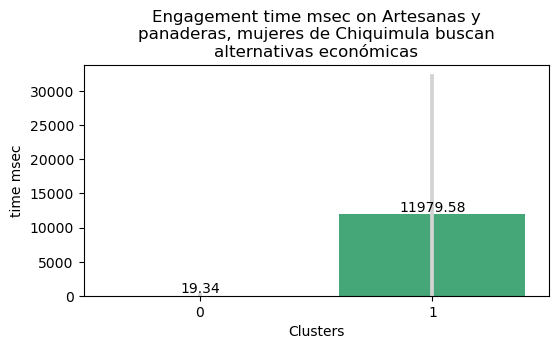

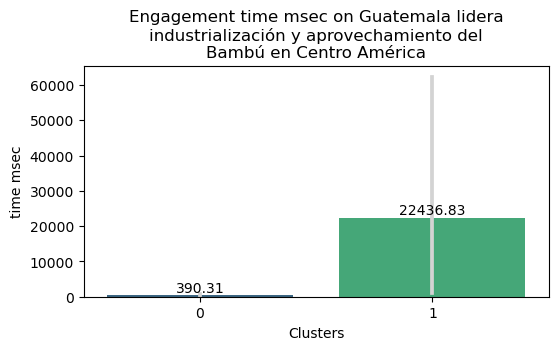

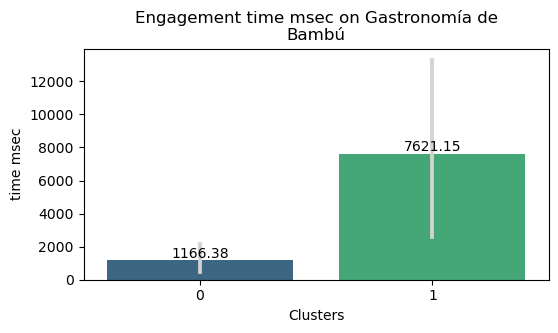

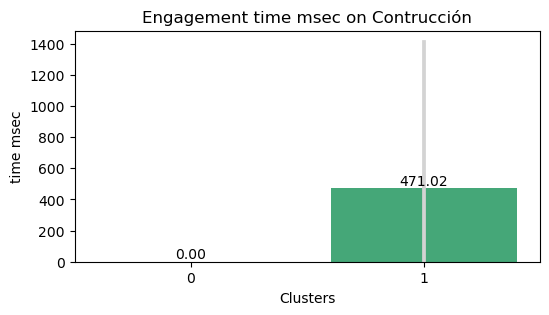

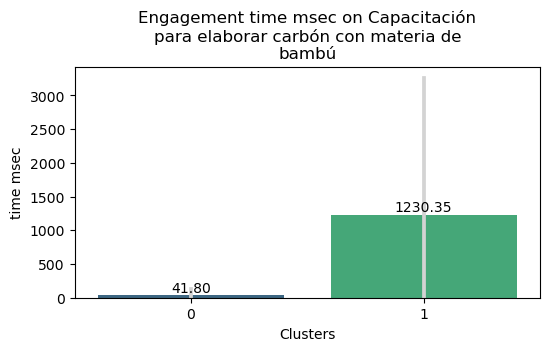

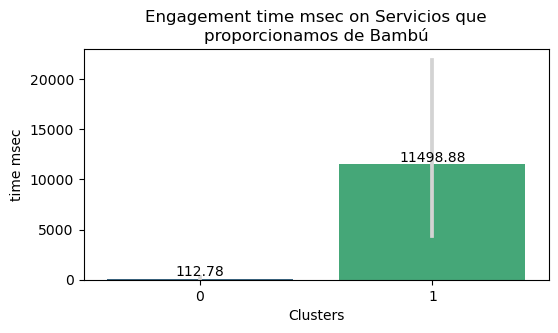

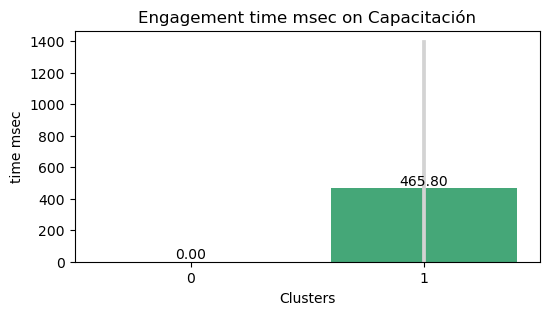

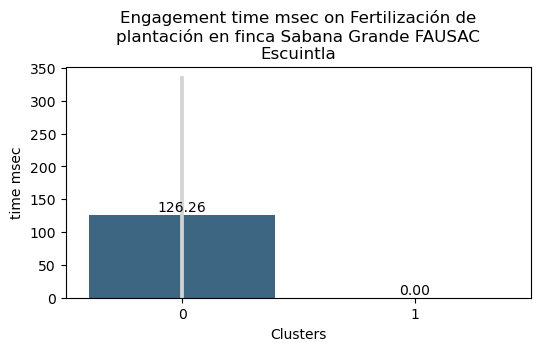

/Users/linjheyu/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


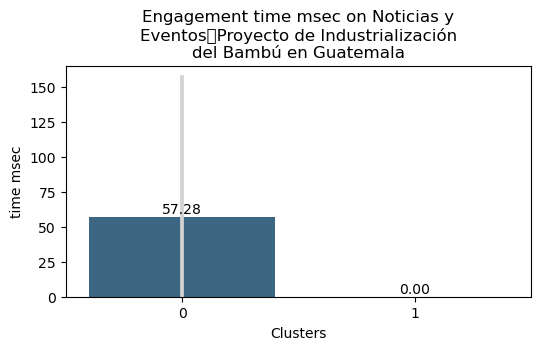

In [35]:
import textwrap

# Assuming user_data_filtered is your DataFrame
features = user_data_filtered.columns.drop("Clusters")

# Looping through each feature
for feature in features:
    plt.figure(figsize = (6, 3))
    
    # Creating a barplot for each feature
    ax = seaborn.barplot(x = "Clusters", y = feature, data = user_data_filtered, palette = 'viridis', errcolor = "lightgray")
    
    # Wrapping the title if it exceeds the figure width
    wrapped_title = textwrap.fill(feature, width=40)
    plt.title(wrapped_title)
    
    if feature == "Event count":
        plt.ylabel("count")
    else:
        plt.ylabel("time msec")
    
    # Adding values on top of each bar
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 5), 
                    textcoords='offset points')
    
    plt.show()
